In [ ]:
#Add google drive
from google.colab import drive

In [ ]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#Add link to shared cross section library
#shared library was added as a shortcut to My Drive from the web interface
%env OPENMC_CROSS_SECTIONS = /gdrive/My Drive/data/endfb71_hdf5/cross_sections.xml

env: OPENMC_CROSS_SECTIONS=/gdrive/My Drive/data/endfb71_hdf5/cross_sections.xml


In [ ]:
#Download miniconda and install
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-10-29 15:17:56--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’

Miniconda3-py37_4.8 100%[===================>]  81.12M   117MB/s    in 0.7s    

2020-10-29 15:17:57 (117 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.2’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ | / - \ | / - \ | / - failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: - \ | / - \ | / 

In [ ]:
# Install OpenMC
!conda config --add channels conda-forge
!conda install openmc -y

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [ ]:
import openmc
%matplotlib inline

**Creating Materials for TRISO, coolant, etc.**

In [ ]:
fuel = openmc.Material(name = "Fuel") # UO2 fuel
fuel.add_element("U", 1.0, enrichment = 4.0)
fuel.add_nuclide("O16", 2.0)
fuel.set_density("g/cm3", 10.41)

buffer = openmc.Material(name = "Buffer")
buffer.add_element("C", 1.0)
buffer.set_density("g/cm3", 0.95)
buffer.add_s_alpha_beta("c_Graphite")

IPyC = openmc.Material(name = "Inner PyC")
IPyC.add_element("C", 1.0)
IPyC.set_density("g/cm3", 1.9)
IPyC.add_s_alpha_beta("c_Graphite")

SiC = openmc.Material(name = "SiC")
SiC.add_element("Si", 0.5)
SiC.add_element("C", 0.5)
SiC.set_density("g/cm3", 3.18)

OPyC = openmc.Material(name = "Outer PyC")
OPyC.add_element("C", 1.0)
OPyC.set_density("g/cm3", 1.9)
OPyC.add_s_alpha_beta("c_Graphite")

graphite = openmc.Material(name = "Graphite")
graphite.add_element("C", 1.0)
graphite.set_density("g/cm3", 1.7)
graphite.add_s_alpha_beta("c_Graphite")

helium = openmc.Material(name = "Helium")
helium.add_element("He", 1.0)
helium.set_density("g/cm3", 0.000166)

b4c = openmc.Material(name = "B4C Poison")
b4c.add_element("B", 4.0, enrichment=18.7, enrichment_target='B10',enrichment_type='wo')
b4c.add_element("C", 1.0)
b4c.set_density("g/cm3", 1.82)

# Instantiate a Materials collection
mats_list = [fuel, buffer, IPyC, SiC, OPyC, graphite, helium, b4c]
mats_file = openmc.Materials(mats_list)

# Export to "materials.xml"
mats_file.export_to_xml()
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1" name="Fuel">
    <density units="g/cm3" value="10.41" />
    <nuclide ao="0.0003619114009591381" name="U234" />
    <nuclide ao="0.040490680352735786" name="U235" />
    <nuclide ao="0.958961941481966" name="U238" />
    <nuclide ao="0.0001854667643390831" name="U236" />
    <nuclide ao="2.0" name="O16" />
  </material>
  <material id="2" name="Buffer">
    <density units="g/cm3" value="0.95" />
    <nuclide ao="1.0" name="C0" />
    <sab name="c_Graphite" />
  </material>
  <material id="3" name="Inner PyC">
    <density units="g/cm3" value="1.9" />
    <nuclide ao="1.0" name="C0" />
    <sab name="c_Graphite" />
  </material>
  <material id="4" name="SiC">
    <density units="g/cm3" value="3.18" />
    <nuclide ao="0.4611484" name="Si28" />
    <nuclide ao="0.0234158" name="Si29" />
    <nuclide ao="0.0154358" name="Si30" />
    <nuclide ao="0.5" name="C0" />
  </material>
  <material id="5" name=

**Creating Geometry of TRISO Particles**

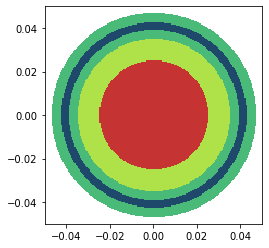

In [ ]:
# Define geometry of each TRISO particle

kernelsph = openmc.Sphere(r=250e-4)
buffsph = openmc.Sphere(r=350e-4)
IPyCsph = openmc.Sphere(r=390e-4)
SiCsph = openmc.Sphere(r=425e-4)
OPyCsph = openmc.Sphere(r=470e-4)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
triso_mats = [fuel, buffer, IPyC, SiC, OPyC]
triso_cells = []
for i in range(5):
  if (i == 0):
    triso_cells.append(openmc.Cell(fill=triso_mats[0], region=-layers[0]))
  else:
    triso_cells.append(openmc.Cell(fill=triso_mats[i], region=+layers[i-1] & -layers[i]))

triso_universe = openmc.Universe(cells=triso_cells)
triso_colors = {triso_cells[0]: (0.78, 0.2, 0.2), triso_cells[1]: (0.69, 0.89, 0.29), 
                triso_cells[2]: (0.29, 0.73, 0.47), triso_cells[3]: (0.12, 0.29, 0.42), 
                triso_cells[4]: (0.29, 0.73, 0.47)}
triso_universe.plot(width = (0.1, 0.1), colors = triso_colors)

In [ ]:
print(triso_cells)

[Cell
	ID             =	1
	Name           =	
	Fill           =	Material 1
	Region         =	-1
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	2
	Name           =	
	Fill           =	Material 2
	Region         =	(1 -2)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	3
	Name           =	
	Fill           =	Material 3
	Region         =	(2 -3)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	4
	Name           =	
	Fill           =	Material 4
	Region         =	(3 -4)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
, Cell
	ID             =	5
	Name           =	
	Fill           =	Material 5
	Region         =	(4 -5)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None
]


**Generating TRISO Particle Lattice in Cylindrical Pin Cell**

In [ ]:
cylsurf = openmc.ZCylinder(r=0.6225)
maxz = openmc.ZPlane(z0 = 1.95, boundary_type='reflective')
minz = openmc.ZPlane(z0 = -1.95, boundary_type='reflective')

lattice_region = -cylsurf & -maxz & +minz
triso_outer_radius = 465e-4
spheres = openmc.model.pack_spheres(radius=triso_outer_radius, region=lattice_region, pf=0.3)

In [ ]:
triso_particles = [openmc.model.TRISO(triso_outer_radius, fill=triso_universe, center=c) for c in spheres]

In [ ]:
print(triso_particles[0])
vol_triso = 4/3 * 3.14 * triso_outer_radius**3 * len(triso_particles)
actual_pf = vol_triso/(3.14 * (0.6225) ** 2 * 3.9)
print(actual_pf)

Cell
	ID             =	6
	Name           =	
	Fill           =	1
	Region         =	-9
	Rotation       =	None
	Translation    =	[ 0.12133295 -0.17279221  1.00418997]
	Volume         =	None

0.29991587033956024


In [ ]:
lattice_cell = openmc.Cell(region=lattice_region)
lower_left, upp_right = lattice_cell.region.bounding_box
shape = (4, 4, 4)
pitch = (upp_right - lower_left)/shape
triso_latt = openmc.model.create_triso_lattice(triso_particles, lower_left, pitch, shape, graphite)
lattice_cell.fill = triso_latt

lattice_universe = openmc.Universe(cells=[lattice_cell])

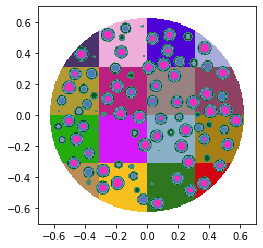

In [ ]:
lattice_universe.plot(width=(1.4,1.4))

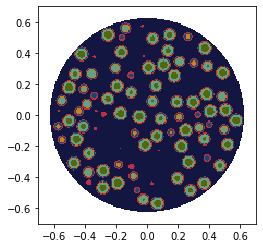

In [ ]:
lattice_universe.plot(width=(1.4,1.4), color_by='material', colors = {graphite: (0.08, 0.09, 0.26)})

**Testing Pin Cell Embedded In Graphite Block**

In [ ]:
hexaregion = openmc.model.hexagonal_prism(edge_length = 0.85, orientation = 'x', boundary_type='reflective')

outer_region = hexaregion & +cylsurf & -maxz & +minz
outer_pin_cell = openmc.Cell(fill=graphite, region = outer_region)

In [ ]:
pin_cell_universe = openmc.Universe(cells=[lattice_cell, outer_pin_cell])

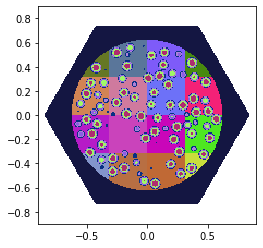

In [ ]:
pin_cell_universe.plot(width=(1.8, 1.8), color_by='cell', colors = {outer_pin_cell: (0.08, 0.09, 0.26)})

As expected, the outside hexagonal block and the non-triso area of the pin cell are both filled with graphite:

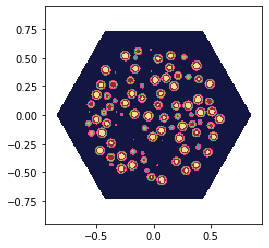

In [ ]:
pin_cell_universe.plot(width=(1.9, 1.9), color_by='material', colors = {graphite: (0.08, 0.09, 0.26), fuel: (1, 0.86, 0.57)})

**Testing the Pin Cell Using OpenMC's Monte Carlo Simulation**

In [ ]:
geom = openmc.Geometry(pin_cell_universe)
geom.export_to_xml()
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="1" material="1" region="-1" universe="1" />
  <cell id="2" material="2" region="1 -2" universe="1" />
  <cell id="3" material="3" region="2 -3" universe="1" />
  <cell id="4" material="4" region="3 -4" universe="1" />
  <cell id="5" material="5" region="4 -5" universe="1" />
  <cell fill="2" id="3387" region="-6 -7 8" universe="69" />
  <cell fill="1" id="3388" region="-3390" translation="-0.03429204821387756 -0.017167205453551965 0.5166899744439695" universe="41" />
  <cell fill="1" id="3389" region="-3391" translation="-0.03429204821387756 -0.017167205453551965 -0.4583100255560306" universe="57" />
  <cell fill="1" id="3390" region="-3392" translation="0.17608954432749213 0.1639676526389588 0.29521248365072617" universe="23" />
  <cell fill="1" id="3391" region="-3393" translation="-0.1351604556725079 0.1639676526389588 0.29521248365072617" universe="24" />
  <cell fill="1" id="3392" region="-3394" translation="0.176089544

In [ ]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>1000</particles>
  <batches>100</batches>
  <inactive>10</inactive>
  <source strength="1.0">
    <space type="point">
      <parameters>0 0 0</parameters>
    </space>
  </source>
</settings>


In [ ]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

**Creating Coolant Channels/Cells (Helium fill)**

In [ ]:
small_coolant_surf = openmc.ZCylinder(r=0.6375)
big_coolant_surf = openmc.ZCylinder(r=0.79375)

small_coolant_cell = openmc.Cell(region = -small_coolant_surf & -maxz & +minz, fill=helium)
big_coolant_cell = openmc.Cell(region = -big_coolant_surf & -maxz & +minz, fill=helium)

outside_small_cell = openmc.Cell(region = +small_coolant_surf & -maxz & +minz, fill=graphite)
outside_big_cell = openmc.Cell(region = +big_coolant_surf & -maxz & +minz, fill=graphite)

small_coolant_universe = openmc.Universe(cells=[small_coolant_cell, outside_small_cell])
big_coolant_universe = openmc.Universe(cells=[big_coolant_cell, outside_big_cell])

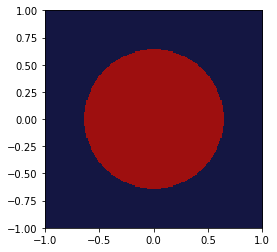

In [ ]:
small_coolant_universe.plot(width=(2.0, 2.0), color_by='material', colors={helium: (0.62, 0.06, 0.06), graphite: (0.08, 0.09, 0.26)})

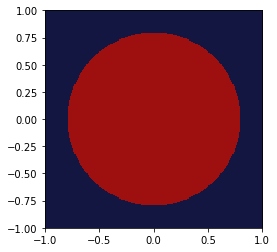

In [ ]:
big_coolant_universe.plot(width=(2.0, 2.0), color_by='material', colors={helium: (0.62, 0.06, 0.06), graphite: (0.08, 0.09, 0.26)})

**Burnable Poison Rod Geometry**

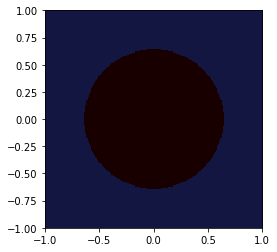

In [ ]:
poison_surf = openmc.ZCylinder(r=0.6375)
poison_cell = openmc.Cell(region=-poison_surf & -maxz & +minz, fill=b4c)
outside_poison_cell = openmc.Cell(region=+poison_surf & -maxz & +minz, fill=graphite)

poison_universe = openmc.Universe(cells=[poison_cell, outside_poison_cell])
poison_universe.plot(width=(2.0, 2.0), color_by = "material", colors={b4c: (0.1, 0, 0), graphite: (0.08, 0.09, 0.26)})

**Defining Material Outside Pin Cell For Use in Assemblies**

In [ ]:
outer_pin_region = +cylsurf & -maxz & +minz
outer_pin_cell = openmc.Cell(fill=graphite, region = outer_pin_region)

total_pin_cell_universe = openmc.Universe(cells=[lattice_cell, outer_pin_cell])

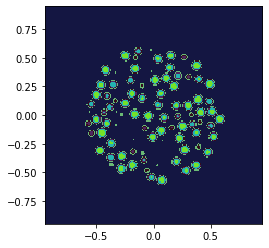

In [ ]:
total_pin_cell_universe.plot(width=(1.9, 1.9), color_by='material', colors = {graphite: (0.08, 0.09, 0.26)})

**Constructing Geometry of Hexagonal Fuel Assembly**

In [ ]:
outer_graphite_cell = openmc.Cell(fill=graphite)
outer_graphite_universe = openmc.Universe(cells=[outer_graphite_cell])

In [ ]:
assemblylat = openmc.HexLattice(name="Assembly")
assemblylat.outer = outer_graphite_universe
assemblylat.pitch = (1.9,)
assemblylat.center = (0.0, 0.0)
assemblylat.orientation = 'x'

In [ ]:
print(assemblylat.show_indices(num_rings=11))

                                                                      ( 0, 0)
                                                               ( 0,59)       ( 0, 1)
                                                        ( 0,58)       ( 1, 0)       ( 0, 2)
                                                 ( 0,57)       ( 1,53)       ( 1, 1)       ( 0, 3)
                                          ( 0,56)       ( 1,52)       ( 2, 0)       ( 1, 2)       ( 0, 4)
                                   ( 0,55)       ( 1,51)       ( 2,47)       ( 2, 1)       ( 1, 3)       ( 0, 5)
                            ( 0,54)       ( 1,50)       ( 2,46)       ( 3, 0)       ( 2, 2)       ( 1, 4)       ( 0, 6)
                     ( 0,53)       ( 1,49)       ( 2,45)       ( 3,41)       ( 3, 1)       ( 2, 3)       ( 1, 5)       ( 0, 7)
              ( 0,52)       ( 1,48)       ( 2,44)       ( 3,40)       ( 4, 0)       ( 3, 2)       ( 2, 4)       ( 1, 6)       ( 0, 8)
       ( 0,51)       ( 1,47)       ( 2,43)    

In [ ]:
def repeat_lat_element(n, pad_left, pad_right):
  ring = []
  for i in range(6):
    ring += pad_left
    for i in range(n):
      ring.extend([total_pin_cell_universe]*2 + [big_coolant_universe])
    ring += pad_right

  return ring

In [ ]:
def build_outer_ring(n, insert_poison_rod):
  REPEAT_SECTION = 2
  ring = []

  # burnable poison rods sides
  poisonring = []
  poisonring += [insert_poison_rod] + [total_pin_cell_universe] + [big_coolant_universe]
  for i in range(REPEAT_SECTION):
      poisonring.extend([total_pin_cell_universe]*2 + [big_coolant_universe])
  poisonring += [total_pin_cell_universe]

  # normal sides
  base = []
  base += [outer_graphite_universe] + [total_pin_cell_universe] + [big_coolant_universe]
  for i in range(REPEAT_SECTION):
      base.extend([total_pin_cell_universe]*2 + [big_coolant_universe])
  base += [total_pin_cell_universe]

  ring.extend(poisonring * n + base * (6 - n))

  return ring

In [ ]:
def build_all_rings(insert_poison_rod):
  rings = []

  outer_ring = build_outer_ring(2, insert_poison_rod)
  rings.append(outer_ring)

  for i in range(1, 8): # rings 1 through 7
    ring_left = []
    ring_right = []
    if (i % 3 == 1):
      ring_left = [big_coolant_universe]
      ring_right = [total_pin_cell_universe]*2
    elif (i % 3 == 2):
      ring_left = [total_pin_cell_universe] + [big_coolant_universe]
    else:
      ring_right = [total_pin_cell_universe]

    n = 0
    if (i <= 3):
      n = 2
    elif (i <= 6):
      n = 1
    else:
      n = 0
    
    cur_ring = repeat_lat_element(n, ring_left, ring_right)
    rings.append(cur_ring)

  inner_ring = []
  for i in range(6):
    inner_ring.extend([total_pin_cell_universe] + [small_coolant_universe])
  rings.append(inner_ring)
  rings.append([outer_graphite_universe]*6)
  rings.append([outer_graphite_universe])

  return rings

In [ ]:
rings = build_all_rings(poison_universe)
assemblylat.universes = rings

In [ ]:
print(assemblylat)

HexLattice
	ID             =	75
	Name           =	Assembly
	Orientation    =	x
	# Rings        =	11
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.9,)
	Outer          =	74
	Universes      
                    74  73  71  73  73  71  73  73  71  73  74
                  73  71  73  73  71  73  73  71  73  73  71  73
                71  73  73  71  73  73  71  73  73  71  73  73  71
              73  73  71  73  73  71  73  73  71  73  73  71  73  73
            73  71  73  73  71  73  73  71  73  73  71  73  73  71  73
          71  73  73  71  73  73  71  73  73  71  73  73  71  73  73  71
        73  73  71  73  73  71  73  73  71  73  73  71  73  73  71  73  73
      73  71  73  73  71  73  73  71  73  73  71  73  73  71  73  73  71  73
    71  73  73  71  73  73  71  73  73  70  73  73  71  73  73  71  73  73  71
  73  73  71  73  73  71  73  73  70  74  74  70  73  73  71  73  73  71  73  73
74  71  73  73  71  73  73  71  73  74  74  74  73  71  73  73  7

In [ ]:
assembly_surf = openmc.model.hexagonal_prism(edge_length=21, orientation='x', boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assemblylat, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])

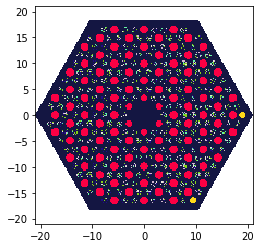

In [ ]:
assembly_universe.plot(width=(42, 42), color_by='material', colors={helium: (0.99, 0, 0.27), graphite: (0.08, 0.09, 0.26), b4c:  (1, 0.85, 0.1)})

**Testing Assembly with OpenMC Simulation**

In [ ]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()
!cat geometry.xml

Streaming output truncated to the last 5000 lines.
  <surface coeffs="-0.01650384293886531 0.09998610548954828 -0.14662046198668133 0.0465" id="4227" type="sphere" />
  <surface coeffs="0.09487251307391097 0.10752065943443795 0.5188395305207409 0.0465" id="4228" type="sphere" />
  <surface coeffs="0.09487251307391097 0.10752065943443795 -0.4561604694792589 0.0465" id="4229" type="sphere" />
  <surface coeffs="-0.057380506674838405 0.11618068356683559 -0.0838386199250516 0.0465" id="4230" type="sphere" />
  <surface coeffs="-0.057380506674838405 -0.19506931643316433 -0.0838386199250516 0.0465" id="4231" type="sphere" />
  <surface coeffs="0.11769856485442765 0.19117883874175962 0.11992958020137712 0.0465" id="4232" type="sphere" />
  <surface coeffs="-0.19355143514557227 0.19117883874175962 0.11992958020137712 0.0465" id="4233" type="sphere" />
  <surface coeffs="0.11769856485442765 -0.12007116125824041 0.11992958020137712 0.0465" id="4234" type="sphere" />
  <surface coeffs="-0.1935514

In [ ]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 5000

settings.export_to_xml()
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>5000</particles>
  <batches>100</batches>
  <inactive>10</inactive>
  <source strength="1.0">
    <space type="point">
      <parameters>0 0 0</parameters>
    </space>
  </source>
</settings>


In [ ]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

**Tally/OpenMC run: 2 burnable poison rods fully in**

In [ ]:
# OpenMC simulation parameters
batches = 100
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

In [ ]:
tallies_file = openmc.Tallies()

energy_filter = openmc.EnergyFilter([0., 0.625, 20.0e6])

tally = openmc.Tally(name='flux')
tally.filters = [openmc.MaterialFilter([fuel, graphite])]
tally.filters.append(energy_filter)
tally.scores = ['flux']
tallies_file.append(tally)

tally = openmc.Tally(name='fuel rxn rates')
tally.filters = [openmc.MaterialFilter(fuel)]
tally.filters.append(energy_filter)
tally.scores = ['nu-fission', 'scatter']
tally.nuclides = ['U238', 'U235']
tallies_file.append(tally)

tally = openmc.Tally(name='moderator rxn rates')
tally.filters = [openmc.MaterialFilter(graphite)]
tally.filters.append(energy_filter)
tally.scores = ['absorption', 'total']
tally.nuclides = ['C0']
tallies_file.append(tally)

# Instantiate a tally mesh
mesh = openmc.RegularMesh(mesh_id=1)
mesh.dimension = [1, 1, 1]
mesh.lower_left = [-10, -10, -1.9]
mesh.width = [20, 20, 3.8]
meshsurface_filter = openmc.MeshSurfaceFilter(mesh)

fiss_rate = openmc.Tally(name='fiss. rate')
abs_rate = openmc.Tally(name='abs. rate')
fiss_rate.scores = ['nu-fission']
abs_rate.scores = ['absorption']
tallies_file += (fiss_rate, abs_rate)

/usr/local/lib/python3.7/site-packages/openmc/mixin.py:68: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


In [ ]:
tallies_file.export_to_xml()
!cat tallies.xml

<?xml version='1.0' encoding='utf-8'?>
<tallies>
  <filter id="13" type="material">
    <bins>1 6</bins>
  </filter>
  <filter id="12" type="energy">
    <bins>0.0 0.625 20000000.0</bins>
  </filter>
  <filter id="14" type="material">
    <bins>1</bins>
  </filter>
  <filter id="15" type="material">
    <bins>6</bins>
  </filter>
  <tally id="15" name="flux">
    <filters>13 12</filters>
    <scores>flux</scores>
  </tally>
  <tally id="16" name="fuel rxn rates">
    <filters>14 12</filters>
    <nuclides>U238 U235</nuclides>
    <scores>nu-fission scatter</scores>
  </tally>
  <tally id="17" name="moderator rxn rates">
    <filters>15 12</filters>
    <nuclides>C0</nuclides>
    <scores>absorption total</scores>
  </tally>
  <tally id="18" name="fiss. rate">
    <scores>nu-fission</scores>
  </tally>
  <tally id="19" name="abs. rate">
    <scores>absorption</scores>
  </tally>
</tallies>


In [ ]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
sp = openmc.StatePoint('statepoint.100.h5')

In [ ]:
flux = sp.get_tally(name='flux')
flux = flux.get_slice(filters=[openmc.MaterialFilter], filter_bins = [(fuel.id,), (graphite.id,)])
flux.get_pandas_dataframe()

,material,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,1,0.000,6.250000e-01,total,flux,1.109420,0.002464
1,1,0.625,2.000000e+07,total,flux,2.995445,0.001392


**Fractional insertion of burnable poison rods**

In [ ]:
def get_fractional_poison(perc):
  """ perc = percent rod is inserted
  i.e. if perc = 25%, then the rod will be 25% B4C, then 75% graphite
  """
  HEIGHT_ROD = 3.9

  height_poison = (perc/100.0) * HEIGHT_ROD
  height_graphite = (1 - perc/100.0) * HEIGHT_ROD

  maxz_poison = openmc.ZPlane(z0 = HEIGHT_ROD/2.0, boundary_type='reflective')
  minz_poison = openmc.ZPlane(z0 = HEIGHT_ROD/2.0 - height_poison)
  maxz_graphite = openmc.ZPlane(z0 = HEIGHT_ROD/2.0 - height_poison)
  minz_graphite = openmc.ZPlane(z0 = -1 * HEIGHT_ROD/2.0, boundary_type='reflective')

  poison_frac_region = -poison_surf & -maxz_poison & +minz_poison
  graphite_frac_region = -poison_surf & -maxz_graphite & +minz_graphite
  outer_region = +poison_surf & -maxz_poison & +minz_graphite

  poison_frac_cell = openmc.Cell(region = poison_frac_region, fill = b4c)
  graphite_frac_cell = openmc.Cell(region = graphite_frac_region, fill = graphite)
  outer_cell = openmc.Cell(region = outer_region, fill = graphite)

  fractional_poison_universe = openmc.Universe(cells=[poison_frac_cell, graphite_frac_cell, outer_cell])

  return fractional_poison_universe

**GEOMETRY: 2 burnable poison rods 50% inserted**

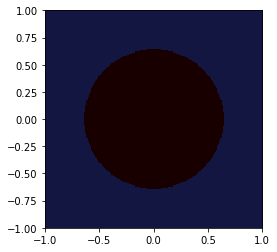

In [ ]:
fractional_poison_universe = get_fractional_poison(50)
fractional_poison_universe.plot(width = (2.0, 2.0), color_by = "material", colors={b4c: (0.1, 0, 0), graphite: (0.08, 0.09, 0.26)})

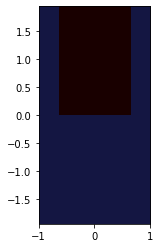

In [ ]:
fractional_poison_universe.plot(origin = (0, 0, 0), width = (2.0, 3.9), basis = "xz", color_by = "material", colors={b4c: (0.1, 0, 0), graphite: (0.08, 0.09, 0.26)})

In [ ]:
assembly50 = openmc.HexLattice(name="Assembly")
assembly50.outer = outer_graphite_universe
assembly50.pitch = (1.9,)
assembly50.center = (0.0, 0.0)
assembly50.orientation = 'x'

In [ ]:
rings = build_all_rings(fractional_poison_universe)
assembly50.universes = rings

In [ ]:
print(assembly50)

HexLattice
	ID             =	79
	Name           =	Assembly
	Orientation    =	x
	# Rings        =	11
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.9,)
	Outer          =	74
	Universes      
                    74  73  71  73  73  71  73  73  71  73  74
                  73  71  73  73  71  73  73  71  73  73  71  73
                71  73  73  71  73  73  71  73  73  71  73  73  71
              73  73  71  73  73  71  73  73  71  73  73  71  73  73
            73  71  73  73  71  73  73  71  73  73  71  73  73  71  73
          71  73  73  71  73  73  71  73  73  71  73  73  71  73  73  71
        73  73  71  73  73  71  73  73  71  73  73  71  73  73  71  73  73
      73  71  73  73  71  73  73  71  73  73  71  73  73  71  73  73  71  73
    71  73  73  71  73  73  71  73  73  70  73  73  71  73  73  71  73  73  71
  73  73  71  73  73  71  73  73  70  74  74  70  73  73  71  73  73  71  73  73
74  71  73  73  71  73  73  71  73  74  74  74  73  71  73  73  7

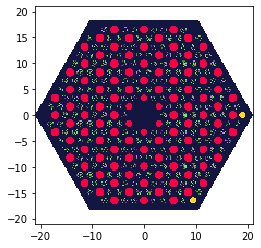

In [ ]:
assembly_surf = openmc.model.hexagonal_prism(edge_length=21, orientation='x', boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assembly50, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])
assembly_universe.plot(width=(42, 42), color_by='material', colors={helium: (0.99, 0, 0.27), graphite: (0.08, 0.09, 0.26), b4c:  (1, 0.85, 0.1)})

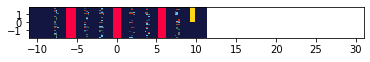

In [ ]:
assembly_universe.plot(origin = (10, -17, 0), width=(42, 3.9), color_by='material', basis = "xz", colors={helium: (0.99, 0, 0.27), graphite: (0.08, 0.09, 0.26), b4c:  (1, 0.85, 0.1)})

**Tallies/OpenMC run on 50% inserted poison rods**

In [ ]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()

In [ ]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

In [ ]:
tallies_file = openmc.Tallies()

energy_filter = openmc.EnergyFilter([0., 0.625, 20.0e6])

tally = openmc.Tally(name='flux')
tally.filters = [openmc.MaterialFilter([fuel, graphite])]
tally.filters.append(energy_filter)
tally.scores = ['flux']
tallies_file.append(tally)

tally = openmc.Tally(name='fuel rxn rates')
tally.filters = [openmc.MaterialFilter(fuel)]
tally.filters.append(energy_filter)
tally.scores = ['nu-fission', 'scatter']
tally.nuclides = ['U238', 'U235']
tallies_file.append(tally)

tally = openmc.Tally(name='moderator rxn rates')
tally.filters = [openmc.MaterialFilter(graphite)]
tally.filters.append(energy_filter)
tally.scores = ['absorption', 'total']
tally.nuclides = ['C0']
tallies_file.append(tally)

# Instantiate a tally mesh
mesh = openmc.RegularMesh(mesh_id=1)
mesh.dimension = [1, 1, 1]
mesh.lower_left = [-10, -10, -1.9]
mesh.width = [20, 20, 3.8]
meshsurface_filter = openmc.MeshSurfaceFilter(mesh)

fiss_rate = openmc.Tally(name='fiss. rate')
abs_rate = openmc.Tally(name='abs. rate')
fiss_rate.scores = ['nu-fission']
abs_rate.scores = ['absorption']
tallies_file += (fiss_rate, abs_rate)
tallies_file.export_to_xml()

In [ ]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

**GEOMETRY: 2 burnable poison rods 25% inserted**

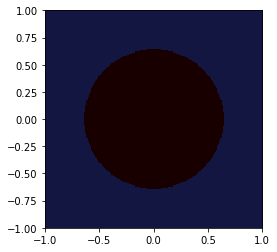

In [ ]:
fractional_poison_universe = get_fractional_poison(25)
fractional_poison_universe.plot(origin = (0, 0, 1.94), width = (2.0, 2.0), basis = "xy", color_by = "material", colors={b4c: (0.1, 0, 0), graphite: (0.08, 0.09, 0.26)})

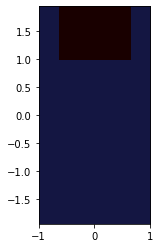

In [ ]:
fractional_poison_universe.plot(origin = (0, 0, 0), width = (2.0, 3.9), basis = "xz", color_by = "material", colors={b4c: (0.1, 0, 0), graphite: (0.08, 0.09, 0.26)})

In [ ]:
assembly25 = openmc.HexLattice(name="Assembly")
assembly25.outer = outer_graphite_universe
assembly25.pitch = (1.9,)
assembly25.center = (0.0, 0.0)
assembly25.orientation = 'x'

In [ ]:
rings = build_all_rings(fractional_poison_universe)
assembly25.universes = rings
print(assembly25)

HexLattice
	ID             =	82
	Name           =	Assembly
	Orientation    =	x
	# Rings        =	11
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.9,)
	Outer          =	74
	Universes      
                    74  73  71  73  73  71  73  73  71  73  74
                  73  71  73  73  71  73  73  71  73  73  71  73
                71  73  73  71  73  73  71  73  73  71  73  73  71
              73  73  71  73  73  71  73  73  71  73  73  71  73  73
            73  71  73  73  71  73  73  71  73  73  71  73  73  71  73
          71  73  73  71  73  73  71  73  73  71  73  73  71  73  73  71
        73  73  71  73  73  71  73  73  71  73  73  71  73  73  71  73  73
      73  71  73  73  71  73  73  71  73  73  71  73  73  71  73  73  71  73
    71  73  73  71  73  73  71  73  73  70  73  73  71  73  73  71  73  73  71
  73  73  71  73  73  71  73  73  70  74  74  70  73  73  71  73  73  71  73  73
74  71  73  73  71  73  73  71  73  74  74  74  73  71  73  73  7

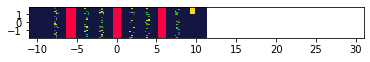

In [ ]:
assembly_surf = openmc.model.hexagonal_prism(edge_length=21, orientation='x', boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assembly25, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])
assembly_universe.plot(origin = (10, -17, 0), width=(42, 3.9), color_by='material', basis = "xz", colors={helium: (0.99, 0, 0.27), graphite: (0.08, 0.09, 0.26), b4c:  (1, 0.85, 0.1)})

In [ ]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()

In [ ]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

In [ ]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

**CMFD Acceleration**

In [ ]:
import openmc.cmfd
import openmc.lib

We return back to the original assembly lattice (2 burnable poison rods fully in), now embedded in a square block of graphite

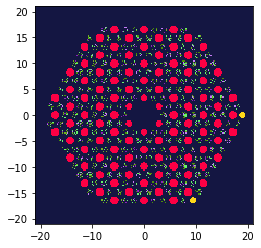

In [ ]:
assembly_surf = openmc.model.rectangular_prism(width = 42, height = 42, boundary_type='reflective')
assembly_cell = openmc.Cell(fill=assemblylat, region=assembly_surf & +minz & -maxz)
assembly_universe = openmc.Universe(cells=[assembly_cell])
assembly_universe.plot(width=(42, 42), color_by='material', colors={helium: (0.99, 0, 0.27), graphite: (0.08, 0.09, 0.26), b4c:  (1, 0.85, 0.1)})

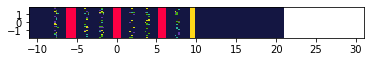

In [ ]:
assembly_universe.plot(origin = (10, -17, 0), width=(42, 3.9), color_by='material', basis = "xz", colors={helium: (0.99, 0, 0.27), graphite: (0.08, 0.09, 0.26), b4c:  (1, 0.85, 0.1)})

In [ ]:
geom = openmc.Geometry(assembly_universe)
geom.export_to_xml()

In [ ]:
# OpenMC simulation parameters
batches = 100
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-5, -5, -0.63, 5, 5, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

In [ ]:
cmfd_mesh = openmc.cmfd.CMFDMesh()
cmfd_mesh.lower_left = (-21, -21, -1.95)
cmfd_mesh.upper_right = (21, 21, 1.95)
cmfd_mesh.dimension = (2, 2, 1)
cmfd_mesh.albedo = [1, 1, 1, 1, 1, 1] # reflective
print(cmfd_mesh)

In [ ]:
cmfd_run = openmc.cmfd.CMFDRun()
cmfd_run.mesh = cmfd_mesh

In [ ]:
with cmfd_run.run_in_memory():
  i = 0
  for _ in cmfd_run.iter_batches():
    i += 1      

 Configuring CMFD parameters for simulation
           CMFD k:    1.07704

           CMFD k:    1.09021

           CMFD k:    1.09357

           CMFD k:    1.10565

           CMFD k:    1.10293

           CMFD k:    1.10385

           CMFD k:    1.10636

           CMFD k:    1.10664

           CMFD k:    1.10567

           CMFD k:    1.10491

           CMFD k:    1.10272

           CMFD k:    1.10142

           CMFD k:    1.10264

           CMFD k:    1.10161

           CMFD k:    1.10203

           CMFD k:    1.10108

           CMFD k:    1.10259

           CMFD k:    1.10240

           CMFD k:    1.10374

           CMFD k:    1.10415

           CMFD k:    1.10386

           CMFD k:    1.10494

           CMFD k:    1.10461

           CMFD k:    1.10450

           CMFD k:    1.10549

           CMFD k:    1.10636

           CMFD k:    1.10665

           CMFD k:    1.10648

           CMFD k:    1.10576

           CMFD k:    1.10490

           CMFD k:    1.10

In [ ]:
sp = openmc.StatePoint('statepoint.100.h5')